## Convolutional DNN

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from attack_utils import get_synonymes#, attack, predict_sentence
import random
import nltk
import operator
from tqdm import tqdm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rusha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rusha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rusha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2
SAVE_MODEL_PATH = './save/model/'
TEXT_DATA = 'data/fake_or_real_news.csv'

In [3]:
# read in our data and preprocess it

df = pd.read_csv(TEXT_DATA)
df.drop(labels=['id','title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [4]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


In [5]:
# vectorize the text samples into a 2D integer tensor 
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Using TensorFlow backend.


Found 99682 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [6]:
# split the data into a training set and a validation set   

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, 
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1), 
                                                  test_size=TEST_SPLIT)

In [7]:
# build a 1D convnet with global maxpooling                                                                      

from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM, 
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        
        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 300)         7500300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4996, 128)         192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 7,709,069
Trainable params: 7,709,069
Non-trainable params: 0
_________________________________________________________________


In [8]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    
    return train_acc, test_acc

In [9]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_ourfakes(model, Fake_texts):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    missclasified_fakes = []
    correct_clasified_fakes = []
    def predict(X):
        return np.rint(model.predict(X))
    # training error
    y_predict = predict(Fake_texts)
    y = np.zeros(len(y_predict))
    for i in range(len(y_predict)):
        missclasified_fakes.append(Fake_texts[i]) if y_predict[i] == 1 else correct_clasified_fakes.append(Fake_texts[i])
    acc = accuracy_score(y,y_predict) #model.evaluate(Fake_texts,y)
    return acc, missclasified_fakes, correct_clasified_fakes

In [10]:
model.load_weights(SAVE_MODEL_PATH+'CNN_model.h5') # replace X with the last saved checkpoint number


In [11]:
def predict_sentence(model,sent):
    try_vector = tokenizer.texts_to_sequences([sent])
    try_vector = pad_sequences([try_vector[0]], 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')
    val = model.predict(try_vector)
    return val


In [12]:
faker = list(df['label'].apply(lambda x: x == 'FAKE'))
fakes = df[faker]
fake_texts = fakes['text']
# fake_labels = fakes['label']

In [13]:
fake_text_vectors = tokenizer.texts_to_sequences(fake_texts)
fake_text_vectors = pad_sequences(fake_text_vectors, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

In [14]:
acc, missclasified_fakes, correct_clasified_fakes = evaluate_ourfakes(model, fake_text_vectors)

In [15]:
print("total missclassified fakes",len(missclasified_fakes),"total correctly classified fakes",len(correct_clasified_fakes))

total missclassified fakes 2 total correctly classified fakes 3162


In [16]:
correct_fakes =tokenizer.sequences_to_texts(correct_clasified_fakes)

In [18]:
# with open(f'CNN1d_correct_fakes.txt','w', encoding="utf-8") as f:
#     f.writelines(correct_fakes)

In [19]:
# with open(f'CNN1d_correct_fakes.txt','r', encoding="utf-8") as f:
#     correct_fakes = f.readlines()

In [34]:
def attack(dummy,pertub=1, printSwaps = False):    
    dummy_temp = nltk.word_tokenize(dummy[:MAX_SEQUENCE_LENGTH])
    second_dummy = dummy_temp
    success_index=[]
    done = False
    unsuccessfullSwaps = 0
    for i in range(int(len(dummy_temp)*pertub)):
        if done:
            break
        itter = 0
        while itter<10000:
            itter+=1
            v = random.randint(0,len(dummy_temp)-1)
            syns,_ = get_synonymes(dummy_temp[v])
            if len(syns)>0:
                break
        if itter == 10000:
            print("didnt catch any synonymes")
            continue
        candidates = {}
        # candidate is a scored candidate dictionary storing all the 
        # synonymes with prediction Score
        word = dummy_temp[v]
        sent = " ".join(dummy_temp)
        candidates[word]=predict_sentence(model,sent)
        for s in syns:
            dummy_temp[v] = s
            sent = (" ".join(dummy_temp))
            val = predict_sentence(model,sent)
            candidates[s] = val
            if val>=0.5:
#                 print("got changes in ",i,val)
                success_index.append(v)
                done = True
                break
    #         best_candidate = max(candidates.iteritems(), key=operator.itemgetter(1))[0]
        best_candidate = max(candidates, key=candidates.get)
        if word == best_candidate:
            unsuccessfullSwaps+=1
        else:
            success_index.append(v)
#             if printSwaps:
#                 print("did not swap")
#         else:
#             if printSwaps:
#             print(word,best_candidate)
        dummy_temp[v] = best_candidate
    if not done:
#         print("sorry")
        return 0,None
    for i in success_index:
        dummy_temp[i] = "<change>"+dummy_temp[i]+','+second_dummy[i]+"<\change>"
    print("swaps done ",i-unsuccessfullSwaps,"total words",len(dummy_temp),"unsucessfull swaps try",unsuccessfullSwaps)
    return i-unsuccessfullSwaps," ".join(dummy_temp)

In [39]:
success_on = np.zeros(len(correct_fakes),dtype='int16')
# for i in tqdm(range(len(correct_fakes))):
# for i in tqdm(range(300)):
for i in tqdm(range(200)):
    success_on[i],_ = attack(correct_fakes[i],1)









  0%|          | 0/299 [00:00<?, ?it/s]







  0%|          | 1/299 [01:47<8:54:14, 107.57s/it]

swaps done  67 total words 455 unsucessfull swaps try 176










  1%|          | 2/299 [03:54<9:20:35, 113.25s/it]

swaps done  85 total words 427 unsucessfull swaps try 199










  1%|          | 3/299 [09:51<15:19:46, 186.44s/it]

swaps done  128 total words 947 unsucessfull swaps try 654










  1%|▏         | 4/299 [14:47<17:58:26, 219.34s/it]







  2%|▏         | 5/299 [16:39<15:16:23, 187.02s/it]







  2%|▏         | 6/299 [17:02<11:14:18, 138.09s/it]







  2%|▏         | 7/299 [17:46<8:54:29, 109.83s/it] 

swaps done  37 total words 145 unsucessfull swaps try 50










  3%|▎         | 8/299 [20:35<10:18:36, 127.55s/it]







  3%|▎         | 9/299 [20:55<7:40:34, 95.29s/it]  

swaps done  25 total words 196 unsucessfull swaps try 30










  3%|▎         | 10/299 [27:00<14:08:49, 176.23s/it]







  4%|▎         | 11/299 [32:02<17:06:25, 213.84s/it]

swaps done  139 total words 713 unsucessfull swaps try 564










  4%|▍         | 12/299 [34:56<16:05:36, 201.87s/it]

swaps done  114 total words 514 unsucessfull swaps try 318










  4%|▍         | 13/299 [41:30<20:37:36, 259.64s/it]







  5%|▍         | 14/299 [43:40<17:28:40, 220.77s/it]







  5%|▌         | 15/299 [51:14<22:55:23, 290.58s/it]







  5%|▌         | 16/299 [53:52<19:42:53, 250.79s/it]







  6%|▌         | 17/299 [55:56<16:40:51, 212.95s/it]

swaps done  74 total words 344 unsucessfull swaps try 230










  6%|▌         | 18/299 [57:19<13:34:22, 173.89s/it]

swaps done  69 total words 258 unsucessfull swaps try 130










  6%|▋         | 19/299 [57:49<10:10:29, 130.82s/it]

swaps done  27 total words 241 unsucessfull swaps try 53










  7%|▋         | 20/299 [1:00:54<11:23:24, 146.97s/it]

swaps done  98 total words 515 unsucessfull swaps try 376










  7%|▋         | 21/299 [1:01:06<8:13:19, 106.47s/it] 

swaps done  23 total words 58 unsucessfull swaps try 6










  7%|▋         | 22/299 [1:03:23<8:53:57, 115.66s/it]

swaps done  69 total words 303 unsucessfull swaps try 211










  8%|▊         | 23/299 [1:04:45<8:04:43, 105.37s/it]

swaps done  56 total words 525 unsucessfull swaps try 163










  8%|▊         | 24/299 [1:06:09<7:33:46, 99.00s/it] 







  8%|▊         | 25/299 [1:08:03<7:52:41, 103.51s/it]







  9%|▊         | 26/299 [1:08:19<5:51:13, 77.19s/it] 







  9%|▉         | 27/299 [1:08:32<4:23:46, 58.18s/it]







  9%|▉         | 28/299 [1:11:25<6:57:47, 92.50s/it]







 10%|▉         | 29/299 [1:14:41<9:15:59, 123.56s/it]

swaps done  94 total words 847 unsucessfull swaps try 342










 10%|█         | 30/299 [1:14:54<6:44:46, 90.28s/it] 







 10%|█         | 31/299 [1:16:31<6:52:14, 92.29s/it]







 11%|█         | 32/299 [1:19:44<9:05:19, 122.55s/it]







 11%|█         | 33/299 [1:22:12<9:37:34, 130.28s/it]







 11%|█▏        | 34/299 [1:24:44<10:03:30, 136.64s/it]

swaps done  87 total words 429 unsucessfull swaps try 273










 12%|█▏        | 35/299 [1:26:22<9:10:43, 125.17s/it] 







 12%|█▏        | 36/299 [1:27:05<7:20:48, 100.56s/it]

swaps done  44 total words 140 unsucessfull swaps try 53










 12%|█▏        | 37/299 [1:28:56<7:33:12, 103.79s/it]







 13%|█▎        | 38/299 [1:36:19<14:53:20, 205.37s/it]







 13%|█▎        | 39/299 [1:37:47<12:17:36, 170.22s/it]

swaps done  62 total words 298 unsucessfull swaps try 155










 13%|█▎        | 40/299 [1:39:43<11:04:59, 154.05s/it]

swaps done  78 total words 375 unsucessfull swaps try 201










 14%|█▎        | 41/299 [1:43:31<12:36:45, 175.99s/it]







 14%|█▍        | 42/299 [1:50:04<17:13:30, 241.28s/it]







 14%|█▍        | 43/299 [1:50:11<12:09:45, 171.04s/it]

swaps done  16 total words 29 unsucessfull swaps try 6










 15%|█▌        | 45/299 [1:53:57<10:50:15, 153.60s/it]







 15%|█▌        | 46/299 [1:59:36<14:41:33, 209.06s/it]

swaps done  114 total words 909 unsucessfull swaps try 600










 16%|█▌        | 47/299 [2:03:25<15:04:09, 215.28s/it]







 16%|█▌        | 48/299 [2:06:19<14:07:41, 202.64s/it]







 16%|█▋        | 49/299 [2:09:45<14:09:30, 203.88s/it]

swaps done  112 total words 494 unsucessfull swaps try 339










 17%|█▋        | 50/299 [2:09:57<10:06:39, 146.18s/it]

swaps done  20 total words 149 unsucessfull swaps try 13










 17%|█▋        | 51/299 [2:14:11<12:17:57, 178.54s/it]







 17%|█▋        | 52/299 [2:20:00<15:45:50, 229.76s/it]

swaps done  143 total words 836 unsucessfull swaps try 637










 18%|█▊        | 53/299 [2:22:02<13:29:26, 197.42s/it]







 18%|█▊        | 54/299 [2:24:37<12:34:21, 184.74s/it]







 18%|█▊        | 55/299 [2:25:53<10:18:29, 152.09s/it]

swaps done  67 total words 244 unsucessfull swaps try 140










 19%|█▊        | 56/299 [2:29:20<11:22:57, 168.63s/it]

swaps done  92 total words 511 unsucessfull swaps try 355










 19%|█▉        | 57/299 [2:34:14<13:50:53, 206.00s/it]







 19%|█▉        | 58/299 [2:37:48<13:58:01, 208.64s/it]

swaps done  104 total words 546 unsucessfull swaps try 345










 20%|█▉        | 59/299 [2:40:00<12:22:13, 185.56s/it]







 20%|██        | 60/299 [2:40:42<9:28:01, 142.60s/it] 







 20%|██        | 61/299 [2:42:21<8:33:33, 129.47s/it]







 21%|██        | 62/299 [2:44:21<8:19:18, 126.41s/it]

swaps done  47 total words 933 unsucessfull swaps try 204










 21%|██        | 63/299 [2:50:15<12:45:56, 194.73s/it]

swaps done  104 total words 918 unsucessfull swaps try 651










 21%|██▏       | 64/299 [2:55:01<14:30:00, 222.13s/it]







 22%|██▏       | 65/299 [2:57:06<12:33:10, 193.12s/it]







 22%|██▏       | 66/299 [2:59:10<11:09:45, 172.47s/it]

swaps done  61 total words 696 unsucessfull swaps try 239










 22%|██▏       | 67/299 [2:59:13<7:50:14, 121.61s/it] 

swaps done  5 total words 18 unsucessfull swaps try 6










 23%|██▎       | 68/299 [3:06:36<13:59:15, 217.99s/it]







 23%|██▎       | 69/299 [3:08:42<12:09:33, 190.32s/it]







 23%|██▎       | 70/299 [3:14:18<14:53:18, 234.05s/it]







 24%|██▎       | 71/299 [3:20:36<17:33:39, 277.28s/it]

swaps done  133 total words 968 unsucessfull swaps try 704










 24%|██▍       | 72/299 [3:21:37<13:23:36, 212.41s/it]

swaps done  64 total words 192 unsucessfull swaps try 99










 24%|██▍       | 73/299 [3:23:30<11:26:49, 182.34s/it]

swaps done  65 total words 266 unsucessfull swaps try 148










 25%|██▍       | 74/299 [3:27:57<12:59:46, 207.94s/it]

swaps done  121 total words 936 unsucessfull swaps try 461










 25%|██▌       | 75/299 [3:28:43<9:54:31, 159.25s/it] 

swaps done  46 total words 112 unsucessfull swaps try 57










 25%|██▌       | 76/299 [3:30:22<8:45:05, 141.28s/it]







 26%|██▌       | 77/299 [3:36:44<13:10:06, 213.54s/it]







 26%|██▌       | 78/299 [3:37:07<9:35:05, 156.13s/it] 







 26%|██▋       | 79/299 [3:41:43<11:44:33, 192.15s/it]







 27%|██▋       | 80/299 [3:47:26<14:26:54, 237.51s/it]







 27%|██▋       | 81/299 [3:50:38<13:33:03, 223.78s/it]

swaps done  94 total words 880 unsucessfull swaps try 351










 27%|██▋       | 82/299 [3:53:13<12:14:30, 203.09s/it]







 28%|██▊       | 83/299 [3:53:48<9:09:47, 152.72s/it] 







 28%|██▊       | 84/299 [3:55:19<8:00:45, 134.16s/it]







 28%|██▊       | 85/299 [3:59:40<10:14:23, 172.26s/it]







 29%|██▉       | 86/299 [4:02:03<9:40:42, 163.58s/it] 

swaps done  89 total words 665 unsucessfull swaps try 264










 29%|██▉       | 87/299 [4:09:16<14:22:55, 244.22s/it]







 29%|██▉       | 88/299 [4:11:05<11:57:00, 203.89s/it]

swaps done  59 total words 486 unsucessfull swaps try 165










 30%|██▉       | 89/299 [4:13:54<11:17:04, 193.45s/it]







 30%|███       | 90/299 [4:16:38<10:43:01, 184.60s/it]

swaps done  83 total words 434 unsucessfull swaps try 336










 30%|███       | 91/299 [4:18:54<9:49:18, 169.99s/it] 







 31%|███       | 92/299 [4:21:37<9:38:32, 167.69s/it]







 31%|███       | 93/299 [4:22:38<7:46:43, 135.94s/it]







 31%|███▏      | 94/299 [4:24:32<7:21:25, 129.20s/it]

swaps done  68 total words 253 unsucessfull swaps try 169










 32%|███▏      | 95/299 [4:27:56<8:35:23, 151.59s/it]

swaps done  95 total words 848 unsucessfull swaps try 470










 32%|███▏      | 96/299 [4:27:58<6:01:37, 106.88s/it]

swaps done  5 total words 26 unsucessfull swaps try 2










 32%|███▏      | 97/299 [4:30:42<6:56:53, 123.83s/it]

swaps done  71 total words 904 unsucessfull swaps try 266










 33%|███▎      | 98/299 [4:31:15<5:23:56, 96.70s/it] 







 33%|███▎      | 99/299 [4:34:49<7:19:18, 131.79s/it]







 33%|███▎      | 100/299 [4:36:35<6:51:57, 124.21s/it]

swaps done  47 total words 529 unsucessfull swaps try 199










 34%|███▍      | 101/299 [4:40:57<9:06:24, 165.58s/it]

swaps done  119 total words 922 unsucessfull swaps try 469










 34%|███▍      | 102/299 [4:45:48<11:06:28, 202.99s/it]







 34%|███▍      | 103/299 [4:50:08<11:59:22, 220.22s/it]

swaps done  128 total words 757 unsucessfull swaps try 448










 35%|███▍      | 104/299 [4:52:03<10:13:26, 188.75s/it]







 35%|███▌      | 105/299 [4:52:23<7:25:49, 137.88s/it] 

swaps done  35 total words 117 unsucessfull swaps try 20










 35%|███▌      | 106/299 [4:52:25<5:12:50, 97.26s/it] 

swaps done  6 total words 45 unsucessfull swaps try 1










 36%|███▌      | 107/299 [4:58:34<9:31:36, 178.63s/it]







 36%|███▌      | 108/299 [5:04:30<12:18:05, 231.86s/it]







 36%|███▋      | 109/299 [5:07:00<10:56:30, 207.32s/it]

swaps done  68 total words 437 unsucessfull swaps try 271










 37%|███▋      | 110/299 [5:07:53<8:27:33, 161.13s/it] 

swaps done  55 total words 128 unsucessfull swaps try 73










 37%|███▋      | 111/299 [5:09:16<7:11:19, 137.65s/it]

swaps done  49 total words 339 unsucessfull swaps try 146










 37%|███▋      | 112/299 [5:11:40<7:14:44, 139.49s/it]

swaps done  41 total words 767 unsucessfull swaps try 258










 38%|███▊      | 113/299 [5:13:54<7:07:19, 137.85s/it]







 38%|███▊      | 114/299 [5:15:25<6:22:06, 123.93s/it]







 38%|███▊      | 115/299 [5:21:30<10:01:24, 196.11s/it]

swaps done  122 total words 911 unsucessfull swaps try 774










 39%|███▉      | 116/299 [5:21:34<7:02:35, 138.56s/it] 

swaps done  7 total words 10 unsucessfull swaps try 3










 39%|███▉      | 117/299 [5:28:28<11:10:45, 221.13s/it]







 39%|███▉      | 118/299 [5:28:39<7:56:48, 158.06s/it] 







 40%|███▉      | 119/299 [5:33:41<10:04:07, 201.38s/it]







 40%|████      | 120/299 [5:40:29<13:06:01, 263.47s/it]







 40%|████      | 121/299 [5:44:09<12:22:41, 250.35s/it]

swaps done  88 total words 875 unsucessfull swaps try 416










 41%|████      | 122/299 [5:49:52<13:40:23, 278.10s/it]







 41%|████      | 123/299 [5:57:28<16:12:37, 331.58s/it]







 41%|████▏     | 124/299 [6:03:43<16:44:58, 344.56s/it]







 42%|████▏     | 125/299 [6:06:57<14:27:39, 299.19s/it]







 42%|████▏     | 126/299 [6:09:08<11:57:57, 249.00s/it]







 42%|████▏     | 127/299 [6:09:14<8:24:49, 176.10s/it] 

swaps done  13 total words 50 unsucessfull swaps try 6










 43%|████▎     | 128/299 [6:12:41<8:48:13, 185.34s/it]







 43%|████▎     | 129/299 [6:16:21<9:14:37, 195.75s/it]

swaps done  103 total words 842 unsucessfull swaps try 377










 43%|████▎     | 130/299 [6:18:05<7:53:19, 168.04s/it]







 44%|████▍     | 131/299 [6:19:08<6:22:37, 136.65s/it]

swaps done  50 total words 234 unsucessfull swaps try 103










 44%|████▍     | 132/299 [6:23:11<7:48:56, 168.48s/it]

swaps done  103 total words 923 unsucessfull swaps try 362










 44%|████▍     | 133/299 [6:25:58<7:44:57, 168.06s/it]







 45%|████▍     | 134/299 [6:26:09<5:32:22, 120.87s/it]







 45%|████▌     | 135/299 [6:32:38<9:10:16, 201.32s/it]







 45%|████▌     | 136/299 [6:37:34<10:24:11, 229.77s/it]

swaps done  139 total words 698 unsucessfull swaps try 509










 46%|████▌     | 137/299 [6:44:59<13:15:00, 294.45s/it]







 46%|████▌     | 138/299 [6:46:25<10:22:06, 231.84s/it]







 46%|████▋     | 139/299 [6:48:55<9:12:38, 207.24s/it] 







 47%|████▋     | 140/299 [6:54:02<10:28:21, 237.12s/it]

swaps done  133 total words 843 unsucessfull swaps try 593










 47%|████▋     | 141/299 [6:59:43<11:46:58, 268.47s/it]







 47%|████▋     | 142/299 [7:05:00<12:20:37, 283.04s/it]

swaps done  143 total words 649 unsucessfull swaps try 472










 48%|████▊     | 143/299 [7:06:49<10:00:04, 230.80s/it]







 48%|████▊     | 144/299 [7:09:39<9:08:35, 212.35s/it] 

swaps done  65 total words 877 unsucessfull swaps try 305










 48%|████▊     | 145/299 [7:10:08<6:44:16, 157.51s/it]







 49%|████▉     | 146/299 [7:16:39<9:40:12, 227.53s/it]







 49%|████▉     | 147/299 [7:19:17<8:43:15, 206.55s/it]

swaps done  74 total words 484 unsucessfull swaps try 264










 49%|████▉     | 148/299 [7:21:14<7:32:09, 179.67s/it]

swaps done  62 total words 861 unsucessfull swaps try 191










 50%|████▉     | 149/299 [7:23:26<6:53:40, 165.47s/it]







 50%|█████     | 150/299 [7:29:13<9:06:27, 220.05s/it]

swaps done  105 total words 993 unsucessfull swaps try 580










 51%|█████     | 151/299 [7:31:26<7:58:00, 193.78s/it]

swaps done  71 total words 333 unsucessfull swaps try 221










 51%|█████     | 152/299 [7:31:55<5:54:04, 144.52s/it]







 51%|█████     | 153/299 [7:37:39<8:16:44, 204.14s/it]







 52%|█████▏    | 154/299 [7:38:57<6:41:55, 166.32s/it]

swaps done  57 total words 450 unsucessfull swaps try 126










 52%|█████▏    | 155/299 [7:39:51<5:18:41, 132.79s/it]

swaps done  57 total words 151 unsucessfull swaps try 79










 52%|█████▏    | 156/299 [7:41:26<4:49:33, 121.49s/it]

swaps done  69 total words 211 unsucessfull swaps try 142










 53%|█████▎    | 157/299 [7:41:59<3:44:41, 94.94s/it] 







 53%|█████▎    | 158/299 [7:43:54<3:57:09, 100.92s/it]







 53%|█████▎    | 159/299 [7:49:03<6:21:05, 163.32s/it]







 54%|█████▎    | 160/299 [7:51:43<6:16:04, 162.34s/it]







 54%|█████▍    | 161/299 [7:54:13<6:04:52, 158.64s/it]







 54%|█████▍    | 162/299 [7:57:11<6:15:26, 164.42s/it]







 55%|█████▍    | 163/299 [7:59:26<5:52:51, 155.68s/it]







 55%|█████▍    | 164/299 [7:59:31<4:08:10, 110.30s/it]

swaps done  11 total words 35 unsucessfull swaps try 1










 55%|█████▌    | 165/299 [8:02:01<4:33:11, 122.33s/it]







 56%|█████▌    | 166/299 [8:02:12<3:17:15, 88.99s/it] 

swaps done  29 total words 65 unsucessfull swaps try 10










 56%|█████▌    | 167/299 [8:07:44<5:55:52, 161.76s/it]







 56%|█████▌    | 168/299 [8:10:41<6:02:57, 166.24s/it]







 57%|█████▋    | 169/299 [8:14:57<6:58:33, 193.18s/it]







 57%|█████▋    | 170/299 [8:18:31<7:08:37, 199.36s/it]

swaps done  87 total words 637 unsucessfull swaps try 391










 57%|█████▋    | 171/299 [8:19:40<5:42:26, 160.52s/it]

swaps done  48 total words 314 unsucessfull swaps try 90










 58%|█████▊    | 172/299 [8:24:00<6:42:49, 190.31s/it]

swaps done  121 total words 858 unsucessfull swaps try 437










 58%|█████▊    | 173/299 [8:30:10<8:32:24, 244.01s/it]







 58%|█████▊    | 174/299 [8:35:50<9:28:24, 272.84s/it]







 59%|█████▊    | 175/299 [8:43:03<11:03:07, 320.86s/it]







 59%|█████▉    | 176/299 [8:45:11<8:59:23, 263.12s/it] 







 59%|█████▉    | 177/299 [8:48:28<8:14:36, 243.25s/it]







 60%|█████▉    | 178/299 [8:53:51<8:59:03, 267.30s/it]

swaps done  88 total words 919 unsucessfull swaps try 654










 60%|█████▉    | 179/299 [8:56:21<7:44:18, 232.15s/it]







 60%|██████    | 180/299 [8:57:13<5:52:48, 177.89s/it]

swaps done  53 total words 183 unsucessfull swaps try 60










 61%|██████    | 181/299 [9:01:18<6:29:33, 198.08s/it]

swaps done  95 total words 722 unsucessfull swaps try 467










 61%|██████    | 182/299 [9:04:20<6:16:41, 193.17s/it]

swaps done  76 total words 902 unsucessfull swaps try 338










 61%|██████    | 183/299 [9:07:38<6:16:17, 194.63s/it]







 62%|██████▏   | 184/299 [9:10:45<6:08:59, 192.52s/it]







 62%|██████▏   | 185/299 [9:16:49<7:43:25, 243.91s/it]

swaps done  126 total words 893 unsucessfull swaps try 659










 62%|██████▏   | 186/299 [9:23:08<8:55:33, 284.36s/it]

swaps done  140 total words 865 unsucessfull swaps try 708










 63%|██████▎   | 187/299 [9:30:22<10:14:33, 329.23s/it]







 63%|██████▎   | 188/299 [9:33:02<8:35:10, 278.48s/it] 

swaps done  98 total words 417 unsucessfull swaps try 256










 63%|██████▎   | 189/299 [9:39:24<9:27:29, 309.54s/it]







 64%|██████▎   | 190/299 [9:43:10<8:36:40, 284.41s/it]







 64%|██████▍   | 191/299 [9:47:09<8:07:51, 271.03s/it]

swaps done  81 total words 850 unsucessfull swaps try 429










 64%|██████▍   | 192/299 [9:48:18<6:15:16, 210.44s/it]







 65%|██████▍   | 193/299 [9:52:13<6:24:27, 217.62s/it]







 65%|██████▍   | 194/299 [9:52:23<4:31:50, 155.34s/it]







 65%|██████▌   | 195/299 [9:57:24<5:44:58, 199.03s/it]







 66%|██████▌   | 196/299 [9:59:40<5:09:15, 180.15s/it]







 66%|██████▌   | 197/299 [10:02:01<4:46:33, 168.57s/it]

swaps done  88 total words 351 unsucessfull swaps try 244










 66%|██████▌   | 198/299 [10:05:26<5:01:49, 179.31s/it]







 67%|██████▋   | 199/299 [10:09:54<5:43:18, 205.98s/it]







 67%|██████▋   | 200/299 [10:13:57<5:58:12, 217.10s/it]

swaps done  102 total words 837 unsucessfull swaps try 463










 67%|██████▋   | 201/299 [10:14:55<4:36:47, 169.46s/it]

swaps done  40 total words 868 unsucessfull swaps try 78










 68%|██████▊   | 202/299 [10:18:49<5:05:13, 188.80s/it]

swaps done  125 total words 677 unsucessfull swaps try 452










 68%|██████▊   | 203/299 [10:22:59<5:31:22, 207.11s/it]

swaps done  72 total words 895 unsucessfull swaps try 410










 68%|██████▊   | 204/299 [10:27:58<6:11:33, 234.67s/it]







 69%|██████▊   | 205/299 [10:31:01<5:43:07, 219.02s/it]

KeyboardInterrupt: 

In [21]:
success_on.dump(SAVE_MODEL_PATH+'CNN_success_rate.npy')

In [43]:
sum(success_on[:200]>0)

85

In [21]:
attack(correct_fakes[0],1)

swaps done  121 total words 919 unsucessfull swaps try 473


(120,
 'think greenfield a journalism fellow at the unsusceptibility center is a new york writer focusing on radical islam in the final move of the vote hillary rodham clinton has gone to operation with the fbi the son “ unprecedented ” give birth been engage around so often this election that it ought to be displace but information technology ’ s wind unprecedented for the nominee of metric linear unit commissioned military officer political party to go war with the fbi but that ’ s exactly what hillary and her be have done patients just waking up now and watching an hour of cnn from their hospital beds would assume that fbi supervisor crowd comey is hillary ’ s adversary in this election the federal bureau of investigation exist under activity by everyone from obama to cnn hillary ’ chemical element multitude have circulated a letter attacking comey there equal currently more occupation hit pieces lambasting him than targeting trump it wouldn ’ nucleotide equal too surprising if the 

In [19]:
success_on= np.load(SAVE_MODEL_PATH+'CNN_success_rate.npy',allow_pickle=True)

In [21]:
success_log = np.zeros((len(correct_fakes),3))

In [22]:
success_log.shape

(3145, 3)

In [23]:
import nltk
for i in range(len(correct_fakes)):
    success_log[i][0] = len(nltk.word_tokenize(correct_fakes[i][:MAX_SEQUENCE_LENGTH]))

In [24]:
success_log.T[1] = success_on

In [25]:
success_log.T[0] 

array([926., 455., 427., ..., 438., 867., 862.])

In [26]:
success_log.T[2] = success_log.T[1]/success_log.T[0]*100

/media/rushabh/B4A46314A462D87E/aml/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [40]:
for i in range(200):
    if success_log.T[2][i]==0:
        success_log.T[2][i]=100

In [86]:
success_log.dump(SAVE_MODEL_PATH+'CNN_success_rate.npy')

In [24]:
x= success_on.T[2][:200]

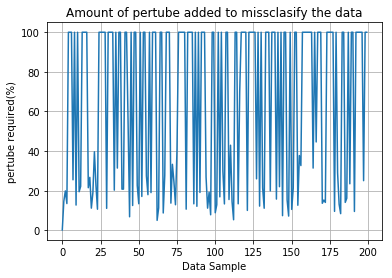

In [25]:
# fig, = plt.plot(x)

fig, ax = plt.subplots()
ax.plot(x)

ax.set(xlabel='Data Sample', ylabel='pertube required(%)',
       title='Amount of pertube added to missclasify the data')
ax.grid()

fig.savefig("CNN_pertube(1__0).png")
plt.show()

In [45]:
print("avg amount of pertub required: (in percent)",x.mean())
print("Std  required: ",x.std())
print("minimum pertube  required: (in percent)",x.min())
print("maximum pertube  required: (in percent)",x.max())

avg amount of pertub required: (in percent) 65.31686395153548
Std  required:  40.59949749862627
minimum pertube  required: (in percent) 0.21598272138228944
maximum pertube  required: (in percent) 100.0


In [50]:
print("Allowing pertub < 10 % for missclassification",sum(x<10)/2,"% of the data")
print("Allowing pertub < 15 % for missclassification",sum(x<15)/2,"% of the data")
print("Allowing pertub < 25 % for missclassification",sum(x<25)/2,"% of the data")
print("Allowing pertub < 35 % for missclassification",sum(x<35)/2,"% of the data")
print("Allowing pertub < 50 % for missclassification",sum(x<50)/2,"% of the data")

Allowing pertub < 10 % for missclassification 5.5 % of the data
Allowing pertub < 15 % for missclassification 19.5 % of the data
Allowing pertub < 25 % for missclassification 33.0 % of the data
Allowing pertub < 35 % for missclassification 39.5 % of the data
Allowing pertub < 50 % for missclassification 42.0 % of the data


In [27]:
y = np.zeros(101,dtype='int')
for i in x:
    y[int(i)]+=1

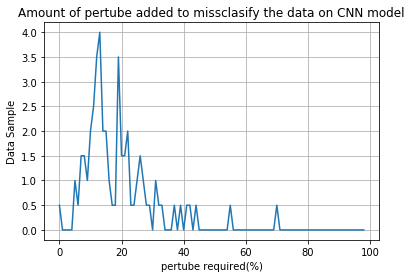

In [33]:
# fig, = plt.plot(x)

fig, ax = plt.subplots()
ax.plot(y[:99]/2)

ax.set(xlabel='pertube required(%)', ylabel='Data Sample',
       title='Amount of pertube added to missclasify the data on CNN model')
ax.grid()

fig.savefig("CNN_pertube(2___0).png")
plt.show()

In [20]:
success_on

array([[9.26000000e+02, 1.21000000e+02, 2.15982721e-01],
       [4.55000000e+02, 6.70000000e+01, 1.47252747e+01],
       [4.27000000e+02, 8.50000000e+01, 1.99063232e+01],
       ...,
       [4.38000000e+02, 0.00000000e+00, 0.00000000e+00],
       [8.67000000e+02, 0.00000000e+00, 0.00000000e+00],
       [8.62000000e+02, 0.00000000e+00, 0.00000000e+00]])

In [21]:
def dif_sentence(S1,S2):
    S1=nltk.word_tokenize(S1)
    S2=nltk.word_tokenize(S2)
    for i in range(len(S1)):
        if S1[i]==S2[i]:
            print(S1[i],end=" ")
        else:
            print("\n",S1[i],S2[i])

In [49]:
attack(correct_fakes[36],1)

swaps done  -61 total words 140 unsucessfull swaps try 67


(-61,
 'lavrov and kerry discuss syrian settlement <change><change>gregorian calendar month,gregorian calendar month<\\change>,<change>gregorian calendar month,gregorian calendar month<\\change><\\change> <change>twenty-eight,twenty-eight<\\change> 2016 <change>metallic element,metallic element<\\change> <change>slavic,slavic<\\change> <change><change>foreigner,foreigner<\\change>,<change>foreigner,foreigner<\\change><\\change> <change>government department,government department<\\change> sergey lavrov and u s secretary of <change>emotional state,emotional state<\\change> john kerry <change><change>hold forth,hold forth<\\change>,<change>hold forth,hold forth<\\change><\\change> the syrian <change>agreement,agreement<\\change> as <change>excavation,excavation<\\change> <change>metric linear unit,metric linear unit<\\change> the <change>state,state<\\change> <change>indiana,indiana<\\change> yemen and libya <change>aside,aside<\\change> telephone <change>along,along<\\change> <change>gr

In [35]:
attack(correct_fakes[168])

(0, None)

In [44]:
np.argmin(success_on.T[2])

344

In [48]:
success_on[36]

array([140.        ,  44.        ,  31.42857143])